In [1]:
import gdown
import pims
import torch as tr
import yaml
import numpy as np
import matplotlib.pyplot as plt

from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root

%load_ext autoreload
%autoreload 2

In [5]:
video = pims.Video(get_project_root() / "resources/test_video.mp4")
video.file = get_project_root() / "resources/test_video.mp4"
print(video.shape, video.frame_rate)

(5395, 720, 1280, 3) 29.97


In [4]:

"""setup all representations we want to use, including one representation per device"""
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict = yaml.safe_load(f"""
normals_svd(depth_marigold):
  type: normals/depth-svd
  dependencies: [depth_marigold]
  parameters:
    sensor_fov: 75
    sensor_width: 3840
    sensor_height: 2160
    window_size: 11
depth_marigold:
  type: depth/marigold
  dependencies: []
  parameters:
    variant: marigold-lcm-v1-0
    denoising_steps: 4
    ensemble_size: 1
    processing_resolution: 768
  device: {device}
# depth_dpt:
#   type: depth/dpt
#   dependencies: []
#   parameters: {{}}
#   device: {device}
""")

video = pims.Video(dwd_video_if_needed())
print(video.shape, video.frame_rate)
start_frame = 1000
end_frame = start_frame + 1

representations = build_representations_from_cfg(all_representations_dict)
print(representations)

representations["depth_marigold"].video = video
representations["normals_svd(depth_marigold)"].video = video
representations["depth_marigold"].vre_setup()

[2024-10-12T18:58:29 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:96)
[2024-10-12T18:58:29 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:74)
[2024-10-12T18:58:29 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:81)
[2024-10-12T18:58:29 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:74)


(9021, 720, 1280, 3) 29.97
{'depth_marigold': [Representation] Marigold(depth_marigold), 'normals_svd(depth_marigold)': [Representation] DepthNormalsSVD(normals_svd(depth_marigold))}


## Run the representations for two particular frame

3392


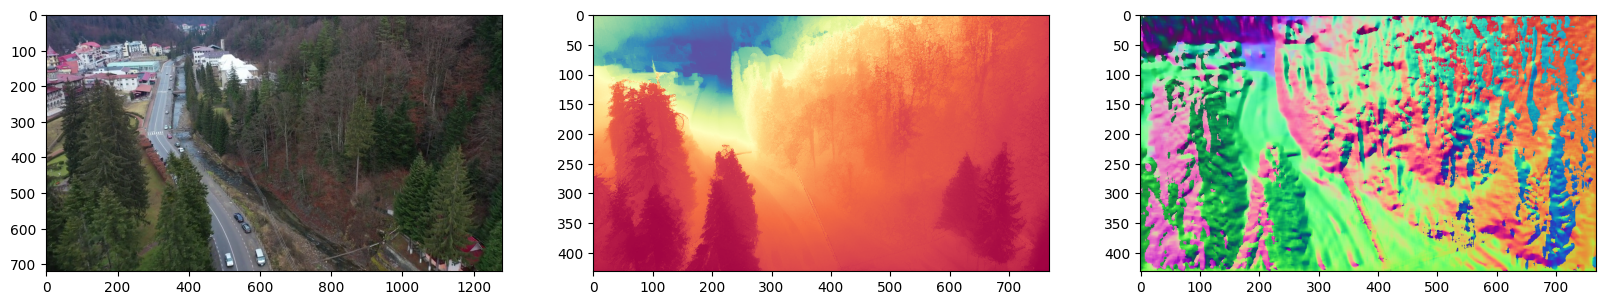

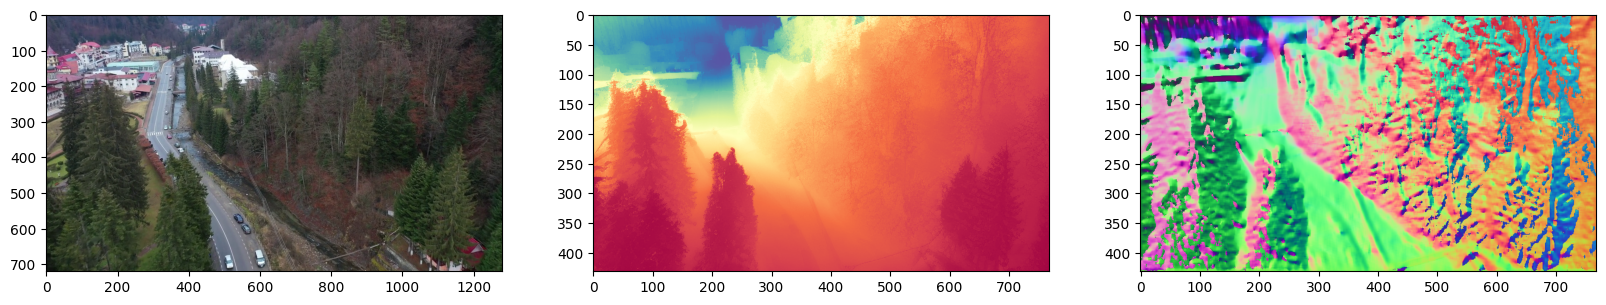

In [9]:
# inference setup (this is done inside VRE's main loop at run() as well)
depth, normals = representations["depth_marigold"], representations["normals_svd(depth_marigold)"]

np.random.seed(43)
start = np.random.randint(0, len(video) - 1)
print(start)
mb = 2
slc = slice(start, start + mb)

frames = np.array(video[slc])
y_depth = depth.make(frames)
y_depth_img = depth.make_images(frames, y_depth)
y_normals = normals.make(frames, {"depth_marigold": y_depth})
y_normals_img = normals.make_images(frames, y_normals)
for i in range(len(frames)):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(frames[i])
    ax[1].imshow(y_depth_img[i])
    ax[2].imshow(y_normals_img[i])
    plt.show()
